<a href="https://colab.research.google.com/github/IgorVladItis/ItisKpfu/blob/main/IgorVlad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Валютная пара EURUSD** Тайм -фрейм 60 минут Short

In [10]:
from keras.models import Sequential # НС прямого распространения
from keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from keras import utils
from keras.preprocessing import image
from keras.optimizers import Adam, Adadelta

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing
import requests
import json
import datetime

%matplotlib inline

# ПАРАМЕТРЫ
SLEEP_TIME = 2
RSS_FEED = 'https://rssexport.rbc.ru/rbcnews/news/20/full.rss'
LEXEMS = ['eur','евро','центробанк', 'псж']
TICKER = 'EURUSD'

# Парсер новостей

In [2]:
!pip install feedparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=01c6064e7e7f09dc4923edeaaf4c042468c5de68302449637885f061f0b88cb6
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [3]:
import requests
import time
from collections import deque
import feedparser

In [4]:
def rss_parser(http_client):
    res = dict()
    rss_link = RSS_FEED

    while True:
        try:
            response = http_client.get(rss_link)
        except:
            time.sleep(SLEEP_TIME)
            continue

        feed = feedparser.parse(response.text)

        for entry in feed.entries[::-1]:
            summary = entry['summary']
            title = entry['title']

            news_text = f'{title}\n{summary}'
            # print(news_text, '\n')

            res[title] = summary

        break

    return res

In [5]:
#  Запускаем парсер
news_dict = rss_parser(requests)

news_dict

{'Липецкие власти рассказали, как действовать при угрозе дронов на экзамене': 'Правительство Липецкой области утвердило алгоритм действий выпускников в случае объявления красного или желтого уровня опасности атаки дронов во время экзаменов.',
 'Citigroup оштрафовали на $79 млн из-за ошибки при продаже акций': 'Американский финансовый конгломерат Citigroup оштрафовали на &pound;61,6 млн ($79 млн) за ошибку сотрудника при продаже акций и другие нарушения, сообщил Банк Англии.',
 'В Чувашии машина скорой с мигалками снесла легковушку и перевернулась': 'В Чувашии машина скорой помощи столкнулась с легковым автомобилем Lada Priora, погиб один человек, трое пострадали.',
 'Шохин анонсировал «конкретные сюжеты» по налогам 23 мая': 'На слушаниях в Госдуме 23 мая представят подробности планируемых изменений налоговой системы, заявил глава РСПП. По его словам, базовые подходы кабмина, депутатов и бизнеса совпадают',
 'Усик возглавил рейтинг лучших боксеров мира по версии ESPN': 'Украинец 18 мая 

# NLP анализ новостей

# №1 NER

In [6]:
# Используем русскую предобученную модель NER - Natasha

!pip install natasha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 36.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=1af344281f34fd747fde74c4a30590896ece2498c6a0db87c10da5e35d373291
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=0971c602d223179d929256c2667e3d6d9c693be20434303e7795b06a3c6183cb
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built docopt intervaltree


In [7]:
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,
    DatesExtractor,

    Doc
)

In [8]:
def ner(text):
    res = {
        'topic': '',
        'seriesTime': '',
        'value': '',
        'text': text,
        'person': [],
        'location': [],
        'organization': [],
    }

    morph_vocab = MorphVocab()
    dates_extractor = DatesExtractor(morph_vocab)

    dates = dates_extractor(text)
    for elem in dates:
        res['seriesTime'] = f"{elem.fact.day}.{elem.fact.month}.{elem.fact.year}"
        break

    emb = NewsEmbedding()
    ner_tagger = NewsNERTagger(emb)
    morph_tagger = NewsMorphTagger(emb)
    syntax_parser = NewsSyntaxParser(emb)
    segmenter = Segmenter()
    doc = Doc(text)

    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    obj_flag = False
    if doc.sents:
        for token in doc.sents[0].syntax.tokens:
            # print(token)
            if token.rel == 'obj':
                obj_flag = True
                res['topic'] = token.text
            if token.rel == 'nsubj' and not obj_flag:
                res['topic'] = token.text
            elif token.rel == 'nummod':
                res['value'] += token.text + ' '

    if res['value']:
        res['value'] = res['value'][:-1]

    doc.tag_ner(ner_tagger)
    for span in doc.spans:
        span.normalize(morph_vocab)
        if span.type == 'LOC':
            res['location'].append(span.normal)
        elif span.type == 'PER':
            res['person'].append(span.normal)
        elif span.type == 'ORG':
            res['organization'].append(span.normal)

    return(res)

In [11]:
# Фильтруем по инструменту
final_news_list = []

for header in news_dict:
  ner_dict = ner(news_dict[header])

  print(news_dict[header], ner_dict)
  print('-'*50)

  if ner_dict:
    for organization in ner_dict.get('organization', []):
      if organization and organization.lower():
        for lexem in LEXEMS:
          if lexem in organization.lower():
            final_news_list.append(news_dict[header])

print(f"Всего по теме новостей -", len(final_news_list))

Правительство Липецкой области утвердило алгоритм действий выпускников в случае объявления красного или желтого уровня опасности атаки дронов во время экзаменов. {'topic': 'алгоритм', 'seriesTime': '', 'value': '', 'text': 'Правительство Липецкой области утвердило алгоритм действий выпускников в случае объявления красного или желтого уровня опасности атаки дронов во время экзаменов.', 'person': [], 'location': ['Липецкая область'], 'organization': []}
--------------------------------------------------
Американский финансовый конгломерат Citigroup оштрафовали на &pound;61,6 млн ($79 млн) за ошибку сотрудника при продаже акций и другие нарушения, сообщил Банк Англии. {'topic': 'млн', 'seriesTime': '', 'value': '61,6 79', 'text': 'Американский финансовый конгломерат Citigroup оштрафовали на &pound;61,6 млн ($79 млн) за ошибку сотрудника при продаже акций и другие нарушения, сообщил Банк Англии.', 'person': [], 'location': [], 'organization': ['Citigroup', 'Банк Англии']}
-----------------

# №2 Сентимент

In [12]:
# Воспользуемся русской моделью Dostoevsky

!pip install dostoevsky
!python3 -m dostoevsky download fasttext-social-network-model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227138 sha256=11de46ac6db2d3c1b2bf7cefdbc7fa24d3ad10a3b4bfd7fcf2bc03bdaa8c7b7f
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [13]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

FastTextSocialNetworkModel.MODEL_PATH = '/usr/local/lib/python3.10/dist-packages/dostoevsky/data/models/fasttext-social-network-model.bin'
tokenizer = RegexTokenizer()
sentiment_model = FastTextSocialNetworkModel(tokenizer=tokenizer)

In [14]:
sentiment_results = sentiment_model.predict(final_news_list, k=2)

print(final_news_list)
print(sentiment_results)

['Евгений Сафонов заявил, что не стоит обращать внимание на сообщения о возможном переходе вратаря «Краснодара» и сборной России в ПСЖ']
[{'neutral': 0.8962613940238953, 'negative': 0.07160120457410812}]


In [15]:
# Агрегируем общий сентимент
sentiment_cols = ['neutral', 'negative', 'positive']

final_sentiment_dict = {sentiment_col: 0 for sentiment_col in sentiment_cols}

for sentiment_result in sentiment_results:
  for sentiment_col in sentiment_cols:
    final_sentiment_dict[sentiment_col] += sentiment_result.get(sentiment_col, 0)

for sentiment_col in sentiment_cols:
    final_sentiment_dict[sentiment_col] /= len(sentiment_results)

final_sentiment_dict

{'neutral': 0.8962613940238953,
 'negative': 0.07160120457410812,
 'positive': 0.0}

# Загрузка котировок инструмента

In [16]:
columns = ['Time','TIME','HIGH','LOW','CLOSE','VOLUME']
index = [0,1,10,100]
data = pd.read_csv('EURUSD60.csv', delimiter =';')
data

,Data,Time,OPEN,HIGH,LOW,CLOSE,VOLUME
0,03.06.2011,6:00,1.44867,1.44890,1.44798,1.44843,2361
1,03.06.2011,7:00,1.44845,1.44881,1.44730,1.44730,2691
2,03.06.2011,8:00,1.44732,1.44864,1.44632,1.44847,3135
3,03.06.2011,9:00,1.44846,1.44856,1.44606,1.44801,2990
4,03.06.2011,10:00,1.44803,1.44977,1.44712,1.44922,2773
...,...,...,...,...,...,...,...
64995,26.11.2021,19:00,1.13021,1.13063,1.12907,1.13035,3468
64996,26.11.2021,20:00,1.13039,1.13117,1.12992,1.13086,3846
64997,26.11.2021,21:00,1.13084,1.13223,1.13084,1.13146,2257
64998,26.11.2021,22:00,1.13147,1.13241,1.13138,1.13240,1792


# Блок формирования входного тензора


In [17]:
def blok1(data):
    SHIFTS = [-1, -2, -3, -4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-16,-17,-18,-19,-20]

    SHIFT = -1
    # data['Open#3'] = data['OPEN'].shift(SHIFTS[0], axis=0)
    # data['High#3'] = data['HIGH'].shift(SHIFTS[0], axis=0)
    # data['Low#3'] = data['LOW'].shift(SHIFTS[0], axis=0)
    data['Close#3'] = data['CLOSE'].shift(SHIFTS[0], axis=0)
    data['Volume#3'] = data['VOLUME'].shift(SHIFTS[0], axis=0)

    SHIFT = -2
    # data['Open#4'] = data['OPEN'].shift(SHIFTS[1], axis=0)
    # data['High#4'] = data['HIGH'].shift(SHIFTS[1], axis=0)
    # data['Low#4'] = data['LOW'].shift(SHIFTS[1], axis=0)
    data['Close#4'] = data['CLOSE'].shift(SHIFTS[1], axis=0)
    data['Volume#4'] = data['VOLUME'].shift(SHIFTS[1], axis=0)

    SHIFT = -3
    # data['Open#5'] = data['OPEN'].shift(SHIFTS[2], axis=0)
    # data['High#5'] = data['HIGH'].shift(SHIFTS[2], axis=0)
    # data['Low#5'] = data['LOW'].shift(SHIFTS[2], axis=0)
    data['Close#5'] = data['CLOSE'].shift(SHIFTS[2], axis=0)
    data['Volume#5'] = data['VOLUME'].shift(SHIFTS[2], axis=0)

    SHIFT = -4
    # data['Open#6'] = data['OPEN'].shift(SHIFTS[3], axis=0)
    # data['High#6'] = data['HIGH'].shift(SHIFTS[3], axis=0)
    # data['Low#6'] = data['LOW'].shift(SHIFTS[3], axis=0)
    data['Close#6'] = data['CLOSE'].shift(SHIFTS[3], axis=0)
    data['Volume#6'] = data['VOLUME'].shift(SHIFTS[3], axis=0)

    SHIFT = -5
    # data['Open#7'] = data['OPEN'].shift(SHIFTS[4], axis=0)
    # data['High#7'] = data['HIGH'].shift(SHIFTS[4], axis=0)
    # data['Low#7'] = data['LOW'].shift(SHIFTS[4], axis=0)
    data['Close#7'] = data['CLOSE'].shift(SHIFTS[4], axis=0)
    data['Volume#7'] = data['VOLUME'].shift(SHIFTS[4], axis=0)

    SHIFT = -6
    # data['Open#8'] = data['OPEN'].shift(SHIFTS[5], axis=0)
    # data['High#8'] = data['HIGH'].shift(SHIFTS[5], axis=0)
    # data['Low#8'] = data['LOW'].shift(SHIFTS[5], axis=0)
    data['Close#8'] = data['CLOSE'].shift(SHIFTS[5], axis=0)
    data['Volume#8'] = data['VOLUME'].shift(SHIFTS[5], axis=0)

    SHIFT = -7
    # data['Open#9'] = data['OPEN'].shift(SHIFTS[6], axis=0)
    # data['High#9'] = data['HIGH'].shift(SHIFTS[6], axis=0)
    # data['Low#9'] = data['LOW'].shift(SHIFTS[6], axis=0)
    data['Close#9'] = data['CLOSE'].shift(SHIFTS[6], axis=0)
    data['Volume#9'] = data['VOLUME'].shift(SHIFTS[6], axis=0)

    SHIFT = -8
    # data['Open#10'] = data['OPEN'].shift(SHIFTS[7], axis=0)
    # data['High#10'] = data['HIGH'].shift(SHIFTS[7], axis=0)
    # data['Low#10'] = data['LOW'].shift(SHIFTS[7], axis=0)
    data['Close#10'] = data['CLOSE'].shift(SHIFTS[7], axis=0)
    data['Volume#10'] = data['VOLUME'].shift(SHIFTS[7], axis=0)

    SHIFT = -9
    # data['Open#11'] = data['OPEN'].shift(SHIFTS[8], axis=0)
    # data['High#11'] = data['HIGH'].shift(SHIFTS[8], axis=0)
    # data['Low#11'] = data['LOW'].shift(SHIFTS[8], axis=0)
    data['Close#11'] = data['CLOSE'].shift(SHIFTS[8], axis=0)
    data['Volume#11'] = data['VOLUME'].shift(SHIFTS[8], axis=0)

    SHIFT = -10
    # data['Open#12'] = data['OPEN'].shift(SHIFTS[9], axis=0)
    # data['High#12'] = data['HIGH'].shift(SHIFTS[9], axis=0)
    # data['Low#12'] = data['LOW'].shift(SHIFTS[9], axis=0)
    data['Close#12'] = data['CLOSE'].shift(SHIFTS[9], axis=0)
    data['Volume#12'] = data['VOLUME'].shift(SHIFTS[9], axis=0)

    SHIFT = -11
    # data['Open#13'] = data['OPEN'].shift(SHIFTS[10], axis=0)
    # data['High#13'] = data['HIGH'].shift(SHIFTS[10], axis=0)
    # data['Low#13'] = data['LOW'].shift(SHIFTS[10], axis=0)
    data['Close#13'] = data['CLOSE'].shift(SHIFTS[10], axis=0)
    data['Volume#13'] = data['VOLUME'].shift(SHIFTS[10], axis=0)

    SHIFT = -12
    # data['Open#14'] = data['OPEN'].shift(SHIFTS[11], axis=0)
    # data['High#14'] = data['HIGH'].shift(SHIFTS[11], axis=0)
    # data['Low#14'] = data['LOW'].shift(SHIFTS[11], axis=0)
    data['Close#14'] = data['CLOSE'].shift(SHIFTS[11], axis=0)
    data['Volume#14'] = data['VOLUME'].shift(SHIFTS[11], axis=0)

    SHIFT = -13
    # data['Open#15'] = data['OPEN'].shift(SHIFTS[12], axis=0)
    # data['High#15'] = data['HIGH'].shift(SHIFTS[12], axis=0)
    # data['Low#15'] = data['LOW'].shift(SHIFTS[12], axis=0)
    data['Close#15'] = data['CLOSE'].shift(SHIFTS[12], axis=0)
    data['Volume#15'] = data['VOLUME'].shift(SHIFTS[12], axis=0)

    SHIFT = -14
    # data['Open#16'] = data['OPEN'].shift(SHIFTS[13], axis=0)
    # data['High#16'] = data['HIGH'].shift(SHIFTS[13], axis=0)
    # data['Low#16'] = data['LOW'].shift(SHIFTS[13], axis=0)
    data['Close#16'] = data['CLOSE'].shift(SHIFTS[13], axis=0)
    data['Volume#16'] = data['VOLUME'].shift(SHIFTS[13], axis=0)

    SHIFT = -15
    # data['Open#17'] = data['OPEN'].shift(SHIFTS[14], axis=0)
    # data['High#17'] = data['HIGH'].shift(SHIFTS[14], axis=0)
    # data['Low#17'] = data['LOW'].shift(SHIFTS[14], axis=0)
    data['Close#17'] = data['CLOSE'].shift(SHIFTS[14], axis=0)
    data['Volume#17'] = data['VOLUME'].shift(SHIFTS[14], axis=0)

    SHIFT = -16
    # data['Open#18'] = data['OPEN'].shift(SHIFTS[15], axis=0)
    # data['High#18'] = data['HIGH'].shift(SHIFTS[15], axis=0)
    # data['Low#18'] = data['LOW'].shift(SHIFTS[15], axis=0)
    data['Close#18'] = data['CLOSE'].shift(SHIFTS[15], axis=0)
    data['Volume#18'] = data['VOLUME'].shift(SHIFTS[15], axis=0)

    SHIFT = -17
    # data['Open#19'] = data['OPEN'].shift(SHIFTS[16], axis=0)
    # data['High#19'] = data['HIGH'].shift(SHIFTS[16], axis=0)
    # data['Low#19'] = data['LOW'].shift(SHIFTS[16], axis=0)
    data['Close#19'] = data['CLOSE'].shift(SHIFTS[16], axis=0)
    data['Volume#19'] = data['VOLUME'].shift(SHIFTS[16], axis=0)

    SHIFT = -18
    # data['Open#20'] = data['OPEN'].shift(SHIFTS[17], axis=0)
    # data['High#20'] = data['HIGH'].shift(SHIFTS[17], axis=0)
    # data['Low#20'] = data['LOW'].shift(SHIFTS[17], axis=0)
    data['Close#20'] = data['CLOSE'].shift(SHIFTS[17], axis=0)
    data['Volume#20'] = data['VOLUME'].shift(SHIFTS[17], axis=0)

    SHIFT = -19
    # data['Open#21'] = data['OPEN'].shift(SHIFTS[18], axis=0)
    # data['High#21'] = data['HIGH'].shift(SHIFTS[18], axis=0)
    # data['Low#21'] = data['LOW'].shift(SHIFTS[18], axis=0)
    data['Close#21'] = data['CLOSE'].shift(SHIFTS[18], axis=0)
    data['Volume#21'] = data['VOLUME'].shift(SHIFTS[18], axis=0)

    SHIFT = -20
    # data['Open#22'] = data['OPEN'].shift(SHIFTS[19], axis=0)
    # data['High#22'] = data['HIGH'].shift(SHIFTS[19], axis=0)
    # data['Low#22'] = data['LOW'].shift(SHIFTS[19], axis=0)
    data['Close#22'] = data['CLOSE'].shift(SHIFTS[19], axis=0)
    data['Volume#22'] = data['VOLUME'].shift(SHIFTS[19], axis=0)

    # data['diff#1Close'] = np.append(np.diff(data['CLOSE']), None)
    # data['diff#2Close'] = np.append(np.diff(data['Close#3']), None)


    #data['X1']= data['CLOSE'] > data['Close#3'] and data['Close#3'] < data['Close#4'] and data['Close#4'] < data['Close#5']
    #data['X1']= (data['CLOSE'] - data['Close#3'] > 0)  & (data['Close#3'] - data['Close#4'] < 0)  & (data['Close#4'] - data['Close#5'] < 0)
    #data['X1']= (data['CLOSE'] - data['Close#3'] < 0)  & (data['Close#3'] - data['Close#4'] > 0)  & (data['Close#4'] - data['Close#5'] > 0) & (data['VOLUME'] - data['Volume#3'] > 0)  & (data['Volume#3'] - data['Volume#4'] > 0)  & (data['Volume#4'] - data['Volume#5'] > 0)
    data['X1']= (data['VOLUME'] - data['Volume#3'] > 0)  & (data['Volume#3'] - data['Volume#4'] > 0) | (data['CLOSE'] > data['Close#3']) | (data['Close#3'] > data['Close#4']) | (data['Close#4'] > data['Close#5'])
    #data['X1']= (data['OPEN'] - data['LOW'] > 0.00010)  # LONG
    data = data.dropna()

    return data, min(SHIFTS), max(SHIFTS)


def blok2(data):
    if 'Data' in data:
        del data['Data']
    if 'Time' in data:
        del data['Time']
    if 'OPEN' in data:
        del data['OPEN']
    if 'HIGH' in data:
        del data['HIGH']
    if 'LOW' in data:
        del data['LOW']
    if 'CLOSE' in data:
        del data['CLOSE']
    if 'VOLUME' in data:
        del data['VOLUME']
    if 'Close#3' in data:
        del data['Close#3']
    if 'Volume#3' in data:
        del data['Volume#3']
    if 'Close#4' in data:
        del data['Close#4']
    if 'Volume#4' in data:
        del data['Volume#4']
    # if 'Close#5' in data:
    #     del data['Close#5']
    # if 'Volume#5' in data:
    #     del data['Volume#5']
    return data, None, None


BLOKS = [blok1, blok2]


def prepare_dataframe(data, bloks):
    # Агрегирующая все Блоки функция
    min_shift = None
    max_shift = None
    for blok in bloks:
        data, min_blok, max_blok = blok(data)
        if not min_shift or (min_blok and min_blok < min_shift):
            min_shift = min_blok
        if not max_shift or (max_blok and max_blok > max_shift):
            max_shift = max_blok

    return data, min_shift, max_shift


data, min_shift, max_shift = prepare_dataframe(data, BLOKS)
data

,Close#5,Volume#5,Close#6,Volume#6,Close#7,Volume#7,Close#8,Volume#8,Close#9,Volume#9,...,Volume#18,Close#19,Volume#19,Close#20,Volume#20,Close#21,Volume#21,Close#22,Volume#22,X1
0,1.44801,2990.0,1.44922,2773.0,1.44956,2569.0,1.44905,2340.0,1.44998,2276.0,...,1739.0,1.46527,2022.0,1.46515,3017.0,1.46524,3446.0,1.46324,3262.0,True
1,1.44922,2773.0,1.44956,2569.0,1.44905,2340.0,1.44998,2276.0,1.44721,2244.0,...,2022.0,1.46515,3017.0,1.46524,3446.0,1.46324,3262.0,1.46398,2462.0,True
2,1.44956,2569.0,1.44905,2340.0,1.44998,2276.0,1.44721,2244.0,1.45432,2321.0,...,3017.0,1.46524,3446.0,1.46324,3262.0,1.46398,2462.0,1.46358,2693.0,True
3,1.44905,2340.0,1.44998,2276.0,1.44721,2244.0,1.45432,2321.0,1.45660,2002.0,...,3446.0,1.46324,3262.0,1.46398,2462.0,1.46358,2693.0,1.46381,3153.0,True
4,1.44998,2276.0,1.44721,2244.0,1.45432,2321.0,1.45660,2002.0,1.46017,2366.0,...,3262.0,1.46398,2462.0,1.46358,2693.0,1.46381,3153.0,1.46446,2844.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64975,1.12179,4413.0,1.12179,4091.0,1.12237,3762.0,1.12189,3009.0,1.12210,2389.0,...,6391.0,1.12937,8365.0,1.13167,8390.0,1.13013,7129.0,1.13035,3468.0,True
64976,1.12179,4091.0,1.12237,3762.0,1.12189,3009.0,1.12210,2389.0,1.12241,2194.0,...,8365.0,1.13167,8390.0,1.13013,7129.0,1.13035,3468.0,1.13086,3846.0,False
64977,1.12237,3762.0,1.12189,3009.0,1.12210,2389.0,1.12241,2194.0,1.12316,3726.0,...,8390.0,1.13013,7129.0,1.13035,3468.0,1.13086,3846.0,1.13146,2257.0,False
64978,1.12189,3009.0,1.12210,2389.0,1.12241,2194.0,1.12316,3726.0,1.12339,7789.0,...,7129.0,1.13035,3468.0,1.13086,3846.0,1.13146,2257.0,1.13240,1792.0,True


# Добавляем сентимент новости

In [18]:
for sentiment_col in sentiment_cols:
  data[sentiment_col] = 0

for sentiment_col in sentiment_cols:
  data.loc[data.index[-1], sentiment_col] = final_sentiment_dict[sentiment_col]

data

<ipython-input-18-43688c35718e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[sentiment_col] = 0
<ipython-input-18-43688c35718e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[sentiment_col] = 0
<ipython-input-18-43688c35718e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

,Close#5,Volume#5,Close#6,Volume#6,Close#7,Volume#7,Close#8,Volume#8,Close#9,Volume#9,...,Close#20,Volume#20,Close#21,Volume#21,Close#22,Volume#22,X1,neutral,negative,positive
0,1.44801,2990.0,1.44922,2773.0,1.44956,2569.0,1.44905,2340.0,1.44998,2276.0,...,1.46515,3017.0,1.46524,3446.0,1.46324,3262.0,True,0.000000,0.000000,0
1,1.44922,2773.0,1.44956,2569.0,1.44905,2340.0,1.44998,2276.0,1.44721,2244.0,...,1.46524,3446.0,1.46324,3262.0,1.46398,2462.0,True,0.000000,0.000000,0
2,1.44956,2569.0,1.44905,2340.0,1.44998,2276.0,1.44721,2244.0,1.45432,2321.0,...,1.46324,3262.0,1.46398,2462.0,1.46358,2693.0,True,0.000000,0.000000,0
3,1.44905,2340.0,1.44998,2276.0,1.44721,2244.0,1.45432,2321.0,1.45660,2002.0,...,1.46398,2462.0,1.46358,2693.0,1.46381,3153.0,True,0.000000,0.000000,0
4,1.44998,2276.0,1.44721,2244.0,1.45432,2321.0,1.45660,2002.0,1.46017,2366.0,...,1.46358,2693.0,1.46381,3153.0,1.46446,2844.0,True,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64975,1.12179,4413.0,1.12179,4091.0,1.12237,3762.0,1.12189,3009.0,1.12210,2389.0,...,1.13167,8390.0,1.13013,7129.0,1.13035,3468.0,True,0.000000,0.000000,0
64976,1.12179,4091.0,1.12237,3762.0,1.12189,3009.0,1.12210,2389.0,1.12241,2194.0,...,1.13013,7129.0,1.13035,3468.0,1.13086,3846.0,False,0.000000,0.000000,0
64977,1.12237,3762.0,1.12189,3009.0,1.12210,2389.0,1.12241,2194.0,1.12316,3726.0,...,1.13035,3468.0,1.13086,3846.0,1.13146,2257.0,False,0.000000,0.000000,0
64978,1.12189,3009.0,1.12210,2389.0,1.12241,2194.0,1.12316,3726.0,1.12339,7789.0,...,1.13086,3846.0,1.13146,2257.0,1.13240,1792.0,True,0.000000,0.000000,0


In [19]:
dataset = data.values
#X = dataset[:,0:X.shape[1]].astype(float)
#Y = dataset[:,X.shape[1] - 1]
X = dataset[:,0:36].astype(float)
Y = dataset[:,36]
Y[Y=='False']='0'
Y[Y=='True']='1'
Y = Y.astype(int)
print(X.shape)
print(Y.shape)
print(Y)

(64980, 36)
(64980,)
[1 1 1 ... 0 1 1]


In [20]:
print(data['X1'].shape)

(64980,)


In [21]:
data['X1'].value_counts()
# data = data.drop('X1', 1)

X1
True     59720
False     5260
Name: count, dtype: int64

## Создание обучающей, проверочной и тестовой выборки

In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print (x_train)
print (x_train.shape)
print (x_test.shape)
print (y_train)
print (y_train.shape)
print (y_test.shape)

[[1.13815e+00 1.25400e+03 1.13867e+00 ... 1.12400e+04 1.14357e+00
  1.04960e+04]
 [1.17788e+00 1.45800e+03 1.17785e+00 ... 1.56800e+03 1.17249e+00
  4.80000e+03]
 [1.18123e+00 1.20200e+03 1.18020e+00 ... 5.26700e+03 1.17991e+00
  3.65800e+03]
 ...
 [1.34938e+00 9.33000e+02 1.34925e+00 ... 1.73800e+03 1.34711e+00
  2.60500e+03]
 [1.35447e+00 2.54100e+03 1.35380e+00 ... 5.28000e+02 1.35391e+00
  8.54000e+02]
 [1.35294e+00 2.22800e+03 1.35239e+00 ... 6.62000e+02 1.35158e+00
  7.49000e+02]]
(51984, 36)
(12996, 36)
[1 1 0 ... 1 1 1]
(51984,)
(12996,)


## Создание нейронной сети

Epoch 1/50
42/42 [==============================] - 3s 18ms/step - loss: 0.7848 - accuracy: 0.5804 - val_loss: 0.8986 - val_accuracy: 0.4043
Epoch 2/50
42/42 [==============================] - 0s 11ms/step - loss: 0.6243 - accuracy: 0.7057 - val_loss: 0.6008 - val_accuracy: 0.7877
Epoch 3/50
42/42 [==============================] - 1s 18ms/step - loss: 0.5261 - accuracy: 0.8104 - val_loss: 0.4776 - val_accuracy: 0.8892
Epoch 4/50
42/42 [==============================] - 1s 14ms/step - loss: 0.4466 - accuracy: 0.8688 - val_loss: 0.3747 - val_accuracy: 0.9163
Epoch 5/50
42/42 [==============================] - 1s 14ms/step - loss: 0.3834 - accuracy: 0.8960 - val_loss: 0.3285 - val_accuracy: 0.9172
Epoch 6/50
42/42 [==============================] - 1s 15ms/step - loss: 0.3466 - accuracy: 0.9062 - val_loss: 0.3009 - val_accuracy: 0.9174
Epoch 7/50
42/42 [==============================] - 1s 14ms/step - loss: 0.3214 - accuracy: 0.9108 - val_loss: 0.2908 - val_accuracy: 0.9173
Epoch 8/50
42

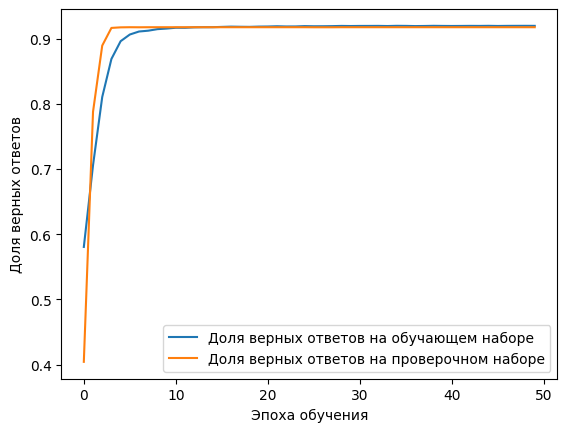

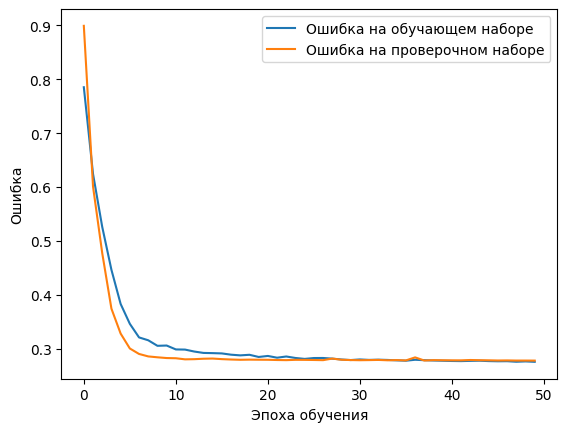

In [31]:
model = Sequential()

model.add(Dense(120, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(30, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    batch_size=1000,
                    epochs=50,
                    validation_split=0.2,
                    verbose=1)

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Выводим графики ошибки
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

model.save('last_model.h5')

## Проверяем качество обучения на тестовом наборе данных

In [24]:
# Вычисляем результаты сети на тестовом наборе
scores = model.evaluate(x_test, y_test, verbose=1)

print(scores)
print("Доля верных ответов на тестовых данных, в процентах: ", round(scores[1] * 100, 4), "%", sep="")

407/407 [==============================] - 1s 2ms/step - loss: 0.2864 - accuracy: 0.9182
[0.2863929867744446, 0.9182056188583374]
Доля верных ответов на тестовых данных, в процентах: 91.8206%


# Телеграм бот

In [25]:
!pip install pytelegrambotapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.9/242.9 kB 2.1 MB/s eta 0:00:00


In [26]:
# Telegram bot
import telebot

In [27]:
TELEGRAM_BOT_TOKEN = "6881884157:AAH5QIReRfKYxMuLr7aEFrpucQHd1EVA25g"
TELEGRAM_URL = "https://api.telegram.org/bot"

CHANEL = "928187359"

In [28]:
class TelegramBot:

    def __init__(self, url=TELEGRAM_URL, token=TELEGRAM_BOT_TOKEN):
        self.url = url + token
        # self.chanel = TELEGRAM_CHANEL
        self.bot = telebot.TeleBot(token)

    def download_file(self, url, file_path):
        r = requests.get(url)
        with open(file_path, 'wb') as outfile:
            outfile.write(r.content)

    def send_img(self, img_file, chanel=None):
        if not chanel:
            chanel = self.chanel
        img = open(img_file, 'rb')
        self.bot.send_photo(chanel, img)
        img.close()

    def send_message(self, text, chanel=None) -> bool:
        if not chanel:
            chanel = self.chanel
        try:
            self.bot.send_message(chanel, text)
        except Exception as e:
            print(str(e))
            return False
        else:
            return True

# Запускаем все вместе

1 - Сигнал на покупку

0 - Сигнал на продажу

In [29]:
y = model.predict(x_test[-1:], batch_size=1000, verbose=1)[-1]
res = round(y[0])
print(res)

1/1 [==============================] - 0s 93ms/step
1


In [30]:
bot = TelegramBot()
msg = f"По инструменту {TICKER} поступил сигнал - "
if res:
  msg += 'Покупать'
else:
  msg += 'Продавать'
bot.send_message(msg, CHANEL)

True